In [1]:
# interactive figure
%matplotlib inline

# auto reload modules
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import matplotlib.ticker as tkr
import matplotlib.gridspec as gridspec
import warnings
from IPython.display import HTML, display
from matplotlib.colors import LinearSegmentedColormap

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

def fxn():
    warnings.warn('deprecated', DeprecationWarning)

In [2]:
class FormatScalarFormatter(tkr.ScalarFormatter):
    def __init__(self, fformat='%1.1f', offset=True, mathText=True):
        self.fformat = fformat
        tkr.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_format(self):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

In [3]:
# bak = xr.open_dataset('/glade/work/zhihuaz/Data/FrontalZone/bak.nc').load()

case = 'spinup'
data_root = '/glade/work/zhihuaz/Data/FrontalZone/' + case
east_uf = xr.open_dataset(data_root+'_east_slice.nc').load()#.sel(time=slice('3.5days','7days'))
south_uf = xr.open_dataset(data_root+'_south_slice.nc').load()#.sel(time=slice('3.5days','7days'))
top_uf = xr.open_dataset(data_root+'_top_slice.nc').load()#.sel(time=slice('3.5days','7days'))
mfd_spinup = xr.open_dataset(data_root+'_averages.nc').load()
mfd_uf = mfd_spinup.sel(time=slice('3.5days',None))

# case = 'r11-Q000-W022-D00-St0'
# data_root = '/glade/work/zhihuaz/Data/FrontalZone/' + case
# east_wind = xr.open_dataset(data_root+'_east_slice.nc').load().sel(time=slice('3.5days','7days'))
# south_wind = xr.open_dataset(data_root+'_south_slice.nc').load().sel(time=slice('3.5days','7days'))
# top_wind = xr.open_dataset(data_root+'_top_slice.nc').load().sel(time=slice('3.5days','7days'))
# mfd_wind = xr.open_dataset(data_root+'_averages.nc').load().sel(time=slice('3.5days','7days'))

# case = 'r11-Q010-W000-D00-St0'
# data_root = '/glade/work/zhihuaz/Data/FrontalZone/' + case
# east_conv = xr.open_dataset(data_root+'_east_slice.nc').load().sel(time=slice('3.5days','7days'))
# south_conv = xr.open_dataset(data_root+'_south_slice.nc').load().sel(time=slice('3.5days','7days'))
# top_conv = xr.open_dataset(data_root+'_top_slice.nc').load().sel(time=slice('3.5days','7days'))
# mfd_conv = xr.open_dataset(data_root+'_averages.nc').load().sel(time=slice('3days','7days'))

# case_list = pd.Index(['unforced', 'wind', 'conv'], name='case')
# east = xr.concat([east_uf,east_wind,east_conv], case_list)
# south = xr.concat([south_uf,south_wind,south_conv], case_list)
# top = xr.concat([top_uf,top_wind,top_conv], case_list)
# mfd = xr.concat([mfd_uf,mfd_wind,mfd_conv], case_list)

In [7]:
# eady = xr.open_dataset('/glade/work/zhihuaz/Data/FrontalZone/eady_mwe.nc')#.load()
# eady.close()
# eady['bt'] = (1e-8 * eady.xC +  1e-8 * (eady.zC + 140) + eady.b).transpose('time','zC','yC','xC')
# eady['Bt'] = eady.bt.mean('yC')
# eady['W'] = eady.w.mean('yC')

ds = xr.open_dataset('/glade/work/zhihuaz/Data/FrontalZone/spinup_top_slice.nc').load().isel(zC=0,zF=0)
ds.close()
ds['bt'] = (-3e-8 * ds.xC + ds.b).transpose('time','yC','xC')

eady = xr.open_dataset('/glade/work/zhihuaz/Data/FrontalZone/spinup_averages.nc').load()
eady.close()
eady['Bt'] = (-3e-8 * eady.xC + eady.B).transpose('time','zC','xC')
dhr = int(((eady.time[1] - eady.time[0])/np.timedelta64(1,'h')).data)
eady

<xarray.Dataset>
Dimensions:  (zC: 64, zF: 65, xC: 512, yF: 512, xF: 512, yC: 512, time: 205)
Coordinates:
  * zC       (zC) float64 -138.3 -134.8 -131.3 -127.9 ... -4.392 -2.635 -0.8781
  * zF       (zF) float64 -140.0 -136.5 -133.0 -129.6 ... -3.513 -1.756 0.0
  * xC       (xC) float64 -499.0 -497.1 -495.1 -493.2 ... 495.1 497.1 499.0
  * yF       (yF) float64 0.0 1.953 3.906 5.859 ... 992.2 994.1 996.1 998.0
  * xF       (xF) float64 -500.0 -498.0 -496.1 -494.1 ... 494.1 496.1 498.0
  * yC       (yC) float64 0.9766 2.93 4.883 6.836 ... 993.2 995.1 997.1 999.0
  * time     (time) timedelta64[ns] 00:00:00 01:00:00 ... 8 days 12:00:00
Data variables:
    B        (time, zC, xC) float64 3.147e-06 3.147e-06 ... 0.0001603 0.0001603
    U        (time, zC, xF) float64 -9.643e-08 -9.648e-08 ... -0.0005324
    W        (time, zF, xC) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    wb       (time, zC, xC) float64 1.399e-16 1.093e-15 ... -5.239e-09
    RiB      (time, zF) float64 20.0 20.0 20.0 20.0 ... 7.658 10.83 9.861 0.0
    KE       (time) float64 5.064e-08 4.979e-09 ... 1.942e-05 1.946e-05
    V        (time, zC, xC) float64 1.226e-08 5.164e-09 ... -0.005421 -0.005475
    adv_cfl  (time) float64 0.85 0.85 0.85 0.85 0.85 ... 0.85 0.85 0.85 0.85
    dif_cfl  (time) float64 0.004751 0.0007449 0.0005232 ... 0.002106 0.002338
    Bt       (time, zC, xC) float64 1.812e-05 1.806e-05 ... 0.0001454 0.0001453
Attributes:
    viscosity_mol:         1e-06
    f:                     0.0001
    schedule:              TimeInterval
    interval:              3600.0
    Oceananigans:          This file was generated using Oceananigans v0.88.0
    Julia:                 This file was generated using Julia Version 1.9.1\...
    output time interval:  Output was saved every 1 hour.
    date:                  This file was generated on 2023-10-22T13:50:29.995.
    diffusivity_mol:       1.5e-07
    M²:                    3e-08

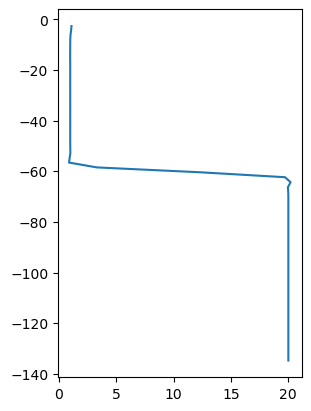

In [4]:
plt.close()
plt.figure(figsize=(3,4), constrained_layout=True)

plt.plot(eady.Bt.isel(time=45).mean('xC').differentiate('zC')[1:-1]*1e-8/(3e-8)**2, eady.zC[1:-1]);
# plt.xlim(0.95,1.05);

In [6]:
eady.W.max()

<xarray.DataArray 'W' ()>
array(0.0012826)

In [20]:
ds.bt.max()

<xarray.DataArray 'bt' ()>
array(0.00017914)
Coordinates:
    zC       float64 -9.668
    zF       float64 -10.55

In [ ]:
plt.close()
fig = plt.figure(figsize=(5,6), constrained_layout=True)
gs = gridspec.GridSpec(9,1, figure=fig, left=0.1, right=0.9, bottom=0.1, top=0.9,
                       wspace=0.05, hspace=0.05)

itime = 0

ax1 = fig.add_subplot(gs[:6, 0])
kw_w1 = {'norm': mcolors.CenteredNorm(),
       'levels': np.linspace(-6e-3,6e-3,31),
       'extend': 'both',
       'cmap': 'RdBu_r'
      }
kw_b1 = {'levels': np.arange(12,18,0.5)*1e-5,
       'colors': 'k', 
       'linewidths': 0.2
      }
Cw1 = ax1.contourf(ds.xC, ds.yC, ds.w.isel(time=itime), **kw_w1)
Cb1 = ax1.contour(ds.xC, ds.yC, ds.bt.isel(time=itime), **kw_b1)
cbar1 = fig.colorbar(Cw1, ax=ax1, fraction=0.027, format=FormatScalarFormatter('%.0f'))

ax2 = fig.add_subplot(gs[6:, 0], sharex=ax1)
kw_w2 = {'norm': mcolors.CenteredNorm(),
       'levels': np.linspace(-9e-4,9e-4,31),
       'extend': 'both',
       'cmap': 'RdBu_r'
      }
kw_b2 = {'levels': np.arange(-1,18,0.5)*1e-5, #np.arange(-1,2.36,0.07)*1e-5, 
       'colors': 'k', 
       'linewidths': 1
      }
Cw2 = ax2.contourf(eady.xC, eady.zF, eady.W.isel(time=itime), **kw_w2)
Cb2 = ax2.contour(eady.xC, eady.zC, eady.Bt.isel(time=itime), **kw_b2)
cbar2 = fig.colorbar(Cw2, ax=ax2, fraction=0.5, format=FormatScalarFormatter('%.0f'))

# # plt.savefig('../Figures/eady_u_ymean.png', dpi=150)

def init():
    cbar1.set_label(r'w|$_{z=-10 \:m}$ [m $s^{-1}$]', labelpad=-50)
    cbar1.formatter.set_powerlimits((0, 0))
    cbar1.formatter.set_useMathText(True)
    cbar1.ax.yaxis.set_offset_position('left')
    cbar1.ax.set_yticks([-6e-3, -4e-3, -2e-3, 0, 2e-3, 4e-3, 6e-3])
    ax1.set_title(f't = {(itime*dhr)//24} days, {(itime*dhr)%24} hours')
    ax1.set(aspect=1)
    ax1.axes.get_xaxis().set_visible(False)
    ax1.set_ylabel('Y [m]')

    cbar2.set_label(r'$\langle w\rangle_{y}$ [m $s^{-1}$]', labelpad=-50)
    cbar2.formatter.set_powerlimits((0, 0))
    cbar2.formatter.set_useMathText(True)
    cbar2.ax.yaxis.set_offset_position('left')
    cbar2.ax.set_yticks([-9e-4, -6e-4, -3e-4, 0, 3e-4, 6e-4, 9e-4])
    ax2.set_ylim(-100,0)
    ax2.set_ylabel('Z [m]')
    ax2.set_xlabel('X [m]');
    return Cw1, Cb1, Cw2, Cb2

def update(frame):
    # print(f'i={frame}')
    global Cw1, Cb1, Cw2, Cb2
    # for each frame, get new data and clear old data stored on each artist
    wtop = ds.w.isel(time=frame)
    btop = ds.bt.isel(time=frame)
    w_ymean = eady.W.isel(time=frame)
    b_ymean = eady.Bt.isel(time=frame)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for obj in (Cw1, Cb1, Cw2, Cb2):
            for coll in obj.collections:
                coll.remove()
    # update the plot
    Cw1 = ax1.contourf(ds.xC, ds.yC, wtop, **kw_w1)
    Cb1 = ax1.contour(ds.xC, ds.yC, btop, **kw_b1)
    Cw2 = ax2.contourf(eady.xC, eady.zF, w_ymean, **kw_w2)
    Cb2 = ax2.contour(eady.xC, eady.zC, b_ymean, **kw_b2)
    ax1.set_title(f't = {(frame*dhr)//24} days, {(frame*dhr)%24} hours');
    return Cw1, Cb1, Cw2, Cb2

ani = animation.FuncAnimation(fig=fig, func=update, frames=range(1,eady.dims['time']), init_func=init, #eady.dims['time'],
                              interval=400, repeat_delay=800, blit=True);
plt.close()
display(HTML(ani.to_jshtml()));

In [ ]:
ani.save('../Figures/spinup_anim2d.mp4', writer='ffmpeg', fps=3, dpi=200);

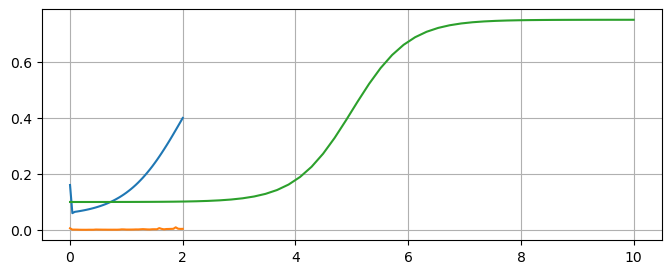

In [12]:
plt.close()
plt.figure(figsize=(8,3))

plt.plot(eady.time/np.timedelta64(1,'D'), eady.adv_cfl);
plt.plot(eady.time/np.timedelta64(1,'D'), eady.dif_cfl);
plt.grid()
plt.plot(np.linspace(0,10), 0.1 + 0.65*(1+np.tanh( (np.linspace(0,10)-5) ))/2);

### Mean KE, mean stratification, mean vertical buoyancy flux

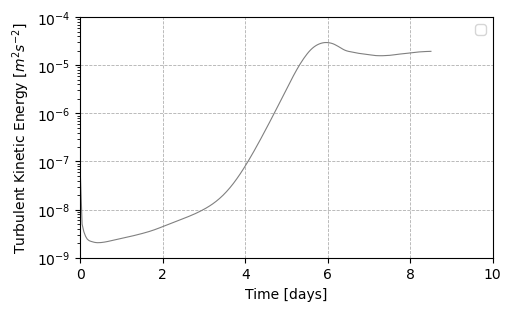

In [4]:
plt.close()
plt.figure(figsize=(5,3), constrained_layout=True)

plt.plot(mfd_spinup.time/np.timedelta64(1,'D'), mfd_spinup.KE, color='gray', lw=0.8, label='_nolegend_')
# plt.plot(mfd_uf.time/np.timedelta64(1,'D'), mfd_uf.KE, lw=2)
# plt.plot(mfd_wind.time/np.timedelta64(1,'D'), mfd_wind.KE, lw=2)
# plt.plot(mfd_conv.time/np.timedelta64(1,'D'), mfd_conv.KE, lw=2)
plt.grid('on', ls='--', lw=0.6)
plt.legend(['Unforced', 'Cross-front wind', 'Convection'])
plt.ylabel(r'Turbulent Kinetic Energy [$m^2 s^{-2}$]')
plt.xlabel('Time [days]');
plt.yscale('log')
plt.xlim(0,10);
plt.ylim(1e-9, 1e-4);
# plt.savefig('../Figures/all_KE.png', dpi=150)

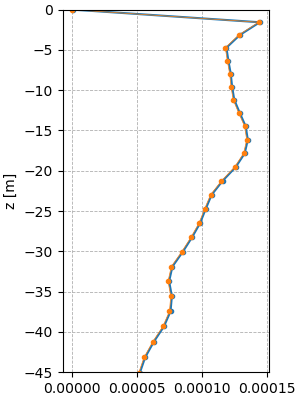

In [6]:
plt.close()
plt.figure(figsize=(3,4), constrained_layout=True)

plt.plot(east['νₑ'].isel(time=23).mean('yC'), mfd.zF, '.-')
plt.plot(east['κₑ'].isel(time=23).mean('yC'), mfd.zF, '.-', lw=0.5)

# plt.xscale('log')
plt.grid('on', ls='--', lw=0.6)
plt.ylim(-45,0)
plt.ylabel('z [m]');


In [ ]:
plt.close()
plt.figure(figsize=(3,4), constrained_layout=True)

plt.plot(mfd['B'].sel(time='0days').mean('xC'), mfd.zC, '--k')
plt.plot(mfd['B'].sel(time='8days').mean('xC'), mfd.zC)

# plt.xscale('symlog')
plt.grid('on', ls='--', lw=0.6)
plt.ylim(-140,0)
plt.ylabel('z [m]');

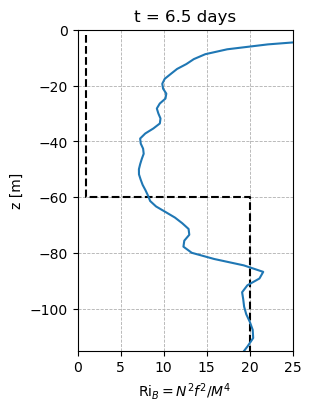

In [8]:
plt.close()
plt.figure(figsize=(3,4), constrained_layout=True)

plt.plot([1,1,20,20], [mfd_uf.zF[-2],-60,-60,-140], '--k')
plt.plot(mfd_uf.RiB.sel(time='8.5 days', method='nearest')[:-1], mfd_uf.zF[:-1]);
# plt.plot(mfd_wind.RiB.sel(time='6.5 days', method='nearest')[:-1], mfd_wind.zF[:-1]);
# plt.plot(mfd_conv.RiB.sel(time='6.5 days', method='nearest')[:-1], mfd_conv.zF[:-1]);

plt.grid('on', ls='--', lw=0.6)
plt.xlim(0,25)
plt.ylim(-115,0)
plt.title('t = 6.5 days')
plt.xlabel(r'Ri$_B = N^2f^2/M^4$')
plt.ylabel('z [m]');
plt.savefig('../Figures/all_RiBprof.png', dpi=150)

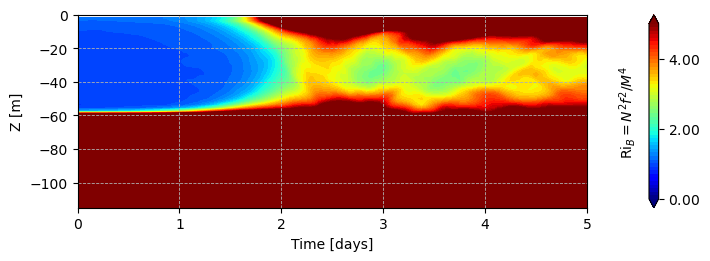

In [6]:
plt.close()
fig = plt.figure(figsize=(7,2.5), constrained_layout=True)

CRiB = plt.contourf((mfd_uf.time-np.timedelta64(3*24+12,'h'))/np.timedelta64(1,'D'), mfd_uf.zF[:-1], 
                     mfd_uf.RiB.transpose('zF','time')[:-1,:], 
                     np.linspace(0,5,50), extend='both', cmap='jet')
# CRiB = plt.contourf((mfd_wind.time-np.timedelta64(3*24+12,'h'))/np.timedelta64(1,'D'), mfd_wind.zF[:-1], 
#                      mfd_wind.RiB.transpose('zF','time')[:-1,:], 
#                      np.linspace(0,5,50), extend='both', cmap='jet')
# CRiB = plt.contourf((mfd_conv.time-np.timedelta64(3*24+12,'h'))/np.timedelta64(1,'D'), mfd_conv.zF[:-1], 
#                      mfd_conv.RiB.transpose('zF','time')[:-1,:], 
#                      np.linspace(0,5,50), extend='both', cmap='jet')

cbar = fig.colorbar(CRiB, ax=plt.gca(), fraction=0.5, pad=0.05, format=FormatScalarFormatter('%.2f'))
cbar.set_label(r'Ri$_B = N^2f^2/M^4$', labelpad=-60)
cbar.ax.set_yticks([0,2,4])

plt.grid('on', ls='--', lw=0.6)
plt.xlim(0,5)
plt.ylim(-115,0)
# plt.title(r'Q = -10 W m$^{-2}$, $\tau$ = 0 N m$^{-2}$')
plt.xlabel('Time [days]');
plt.ylabel('Z [m]');
# case = 'r11-Q010-W000-D00-St0'
# plt.savefig('../Figures/'+case+'_RiB_TZ.png', dpi=150)

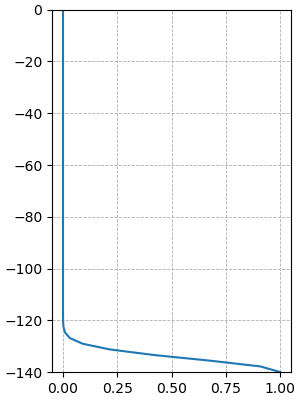

In [13]:
plt.close()
plt.figure(figsize=(3,4), constrained_layout=True)

z = np.linspace(-140,0,65)
plt.plot(np.exp( -(z+140)**2/(2*5**2) ) , z)#* np.heaviside(-120-z,0)
# plt.plot((1+np.tanh( 1.5*(-135-z)/10 ))/2, z)
plt.grid('on', ls='--', lw=0.6);
plt.ylim(-140,0);

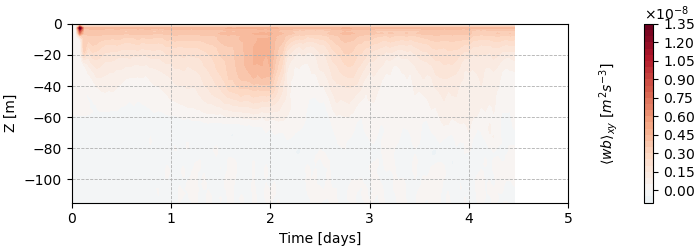

In [46]:
plt.close()
fig = plt.figure(figsize=(7,2.5), constrained_layout=True)

# Cwb = plt.contourf((mfd_uf.time-np.timedelta64(3*24+12,'h'))/np.timedelta64(1,'D'), mfd_uf.zC, 
#                      mfd_uf.wb.mean('xC').transpose('zC','time'), 32, 
#                      norm=mcolors.CenteredNorm(), cmap='RdBu_r')
# Cwb = plt.contourf((mfd_wind.time-np.timedelta64(3*24+12,'h'))/np.timedelta64(1,'D'), mfd_wind.zC, 
#                      mfd_wind.wb.mean('xC').transpose('zC','time'), 32, 
#                      norm=mcolors.CenteredNorm(), cmap='RdBu_r')
Cwb = plt.contourf((mfd_conv.time.sel(time=slice('3.5 days',None))-np.timedelta64(3*24+12,'h'))/np.timedelta64(1,'D'), mfd_conv.zC, 
                     mfd_conv.wb.mean('xC').transpose('zC','time').sel(time=slice('3.5 days',None)), 32,
                     norm=mcolors.CenteredNorm(), cmap='RdBu_r')
cbar = fig.colorbar(Cwb, ax=plt.gca(), fraction=0.5, pad=0.05, format=FormatScalarFormatter('%.2f'))
cbar.set_label(r"$\langle wb \rangle_{xy}$ [$m^2 s^{-3}$]", labelpad=-70)
cbar.ax.yaxis.set_offset_position('left')
# cbar.ax.set_yticks([0,2,4])

plt.grid('on', ls='--', lw=0.6)
plt.xlim(0,5)
plt.ylim(-115,0)
plt.xlabel('Time [days]');
plt.ylabel('Z [m]');

# plt.title(r'Q = -10 W m$^{-2}$, $\tau$ = 0 N m$^{-2}$')
# case = 'spinup'
# case = 'r11-Q010-W000-D00-St0'
# case = 'r11-Q000-W022-D00-St0'
# plt.savefig('../Figures/'+case+'_wb_TZ.png', dpi=150)

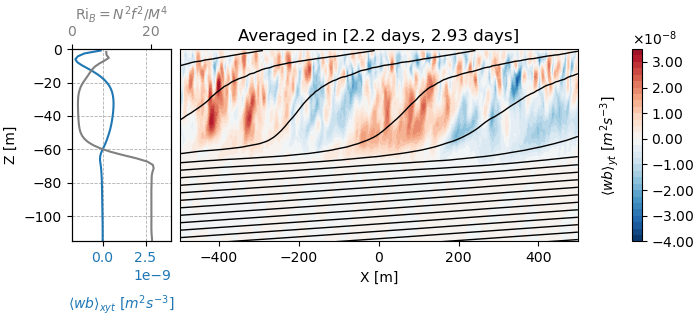

In [56]:
plt.close()
fig = plt.figure(figsize=(7,3.2), constrained_layout=True)
gs = gridspec.GridSpec(1, 5, figure=fig)

# itime = slice('5 days', '5.73 days')
itime = slice('5.2 days', '5.93 days')
ax0 = fig.add_subplot(gs[0, :1])
color = 'C0'
# ax0.plot(mfd_uf.wb.sel(time=itime).mean(['time','xC']), mfd_uf.zC, color=color);
ax0.plot(mfd_wind.wb.sel(time=itime).mean(['time','xC']), mfd_wind.zC, color=color);
# ax0.plot(mfd_conv.wb.sel(time=itime).mean(['time','xC']), mfd_conv.zC, color=color);
ax0.grid('on', ls='--', lw=0.6)
ax0.set_xlim(-1.8e-9,4e-9)
ax0.set_ylabel('Z [m]');
ax0.set_xlabel(r"$\langle wb \rangle_{xyt}$ [$m^2 s^{-3}$]", labelpad=20, color=color);
ax0.tick_params(axis='x', labelcolor=color)

ax0t = ax0.twiny()
color = 'gray'
# ax0t.plot(mfd_uf.RiB.sel(time=itime).mean('time')[:-1], mfd_uf.zF[:-1], color=color)
ax0t.plot(mfd_wind.RiB.sel(time=itime).mean('time')[:-1], mfd_wind.zF[:-1], color=color)
# ax0t.plot(mfd_conv.RiB.sel(time=itime).mean('time')[:-1], mfd_conv.zF[:-1], color=color)
ax0t.set_xlim(0,25)
ax0t.set_xlabel(r'Ri$_B = N^2f^2/M^4$', color=color)
ax0t.tick_params(axis='x', labelcolor=color)

kw = {
    # 'vmin': -7e-8,
    # 'vmax': 7e-8,
    'norm': mcolors.CenteredNorm(),
    # 'shading': 'gouraud',
    'levels': 31,#np.linspace(-7e-8, 7e-8, 24),
    'cmap': 'RdBu_r'
}
ax1 = fig.add_subplot(gs[0, 1:], sharey=ax0)
# Cwb = ax1.contourf(mfd_uf.xC, mfd_uf.zC, mfd_uf['wb'].sel(time=itime).mean('time'), **kw)
Cwb = ax1.contourf(mfd_wind.xC, mfd_uf.zC, mfd_wind['wb'].sel(time=itime).mean('time'), **kw)
# Cwb = ax1.contourf(mfd_conv.xC, mfd_uf.zC, mfd_conv['wb'].sel(time=itime).mean('time'), **kw)

# ax1.contour(mfd_uf.xC, mfd_uf.zC, mfd_uf.B.sel(time=itime).mean('time')+bak.B.isel(yC=0), 
#               np.arange(0,1.9,0.08)*1e-4, colors='k', linewidths=1)
ax1.contour(mfd_wind.xC, mfd_wind.zC, mfd_wind.B.sel(time=itime).mean('time')+bak.B.isel(yC=0), 
              np.arange(0,1.9,0.08)*1e-4, colors='k', linewidths=1)
# ax1.contour(mfd_conv.xC, mfd_conv.zC, mfd_conv.B.sel(time=itime).mean('time')+bak.B.isel(yC=0), 
#               np.arange(0,1.9,0.08)*1e-4, colors='k', linewidths=1)

cbar = fig.colorbar(Cwb, ax=ax1, fraction=0.5, pad=0.05, format=FormatScalarFormatter('%.2f'))
cbar.set_label(r"$\langle wb \rangle_{yt}$ [$m^2 s^{-3}$]", labelpad=-70)
cbar.ax.yaxis.set_offset_position('left')
plt.ylim(-115,0)
ax1.axes.get_yaxis().set_visible(False)
ax1.set_title('Averaged in [2.2 days, 2.93 days]')#f't = {(itime)//24} days, {(itime)%24} hours')
ax1.set_xlabel('X [m]');

# case = 'spinup'
case = 'r11-Q000-W022-D00-St0'
# case = 'r11-Q010-W000-D00-St0'

plt.savefig('../Figures/'+case+'_wb_XZ_time_mean.png', dpi=150)

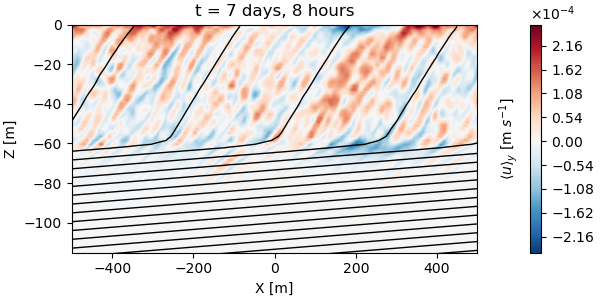

In [25]:
plt.close()
fig = plt.figure(figsize=(6,3), constrained_layout=True)
ax = fig.add_subplot(111)

itime = 166-72
kw0 = {
    # 'vmin': -5e-3,
    # 'vmax': 5e-3,
    'norm': mcolors.CenteredNorm(),
    'levels': 100, #np.linspace(-1e-5, 1e-5, 100),
    'cmap': 'RdBu_r'
}

Cu = ax.contourf(mfd.xF, mfd.zC, mfd.U.isel(time=itime), **kw0)
ax.contour(mfd.xC, mfd.zC, mfd.B.isel(time=itime)+bak.B.isel(yC=0), 
              np.arange(0,1.9,0.08)*1e-4, colors='k', linewidths=1)

cbar = fig.colorbar(Cu, ax=ax, fraction=0.5, pad=0.05, format=FormatScalarFormatter('%.2f'))
cbar.set_label(r'$\langle u\rangle_{y}$ [m $s^{-1}$]', labelpad=-70)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.yaxis.set_offset_position('left')
ax.set_title(f't = {(itime+72)//24} days, {(itime+72)%24} hours')
ax.set_ylim(-115,0)
ax.set_ylabel('Z [m]');
ax.set_xlabel('X [m]');

# plt.savefig('../Figures/'+case+'_UtransectXZ.png', dpi=150)

### Surface map

In [62]:
###patch start###
from mpl_toolkits.mplot3d.axis3d import Axis
if not hasattr(Axis, "_get_coord_info_old"):
    def _get_coord_info_new(self, renderer):
        mins, maxs, centers, deltas, tc, highs = self._get_coord_info_old(renderer)
        mins += deltas / 4
        maxs -= deltas / 4
        return mins, maxs, centers, deltas, tc, highs
    Axis._get_coord_info_old = Axis._get_coord_info  
    Axis._get_coord_info = _get_coord_info_new
###patch end###

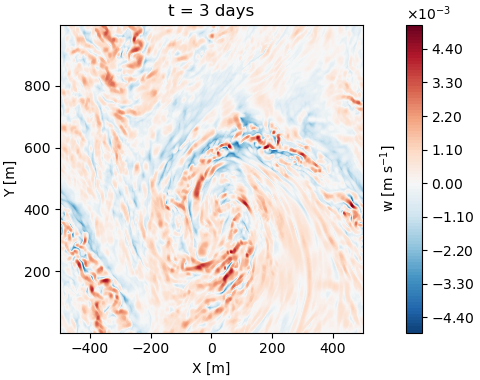

In [70]:
plt.close()
fig = plt.figure(figsize=(4.8,3.8), constrained_layout=True)
ax = fig.add_subplot(111)

itime = '6.5 days'
xroll = -270

kw = {
    # 'vmin': -5e-3,
    # 'vmax': 5e-3,
    'norm': mcolors.CenteredNorm(),
    'levels': 100, #np.linspace(-5e-3, 5e-3, 22),
    'cmap': 'RdBu_r',
    # 'extend': 'both'
}

Ct = plt.contourf(top_uf.xC, top_uf.yC, top_uf.w.sel(time=itime, method='nearest').squeeze().roll(xC=xroll,yC=0), **kw);
cbar = fig.colorbar(Ct, ax=ax, fraction=0.5, pad=0.05, format=FormatScalarFormatter('%.2f'))
cbar.set_label(r'w [m s$^{-1}$]', labelpad=-70)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
# cbar.ax.set_yticks(np.linspace(-5e-3, 5e-3, 6))
cbar.ax.yaxis.set_offset_position('left')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('t = 3 days');
# plt.savefig('../Figures/wtop_217.png', dpi=150);

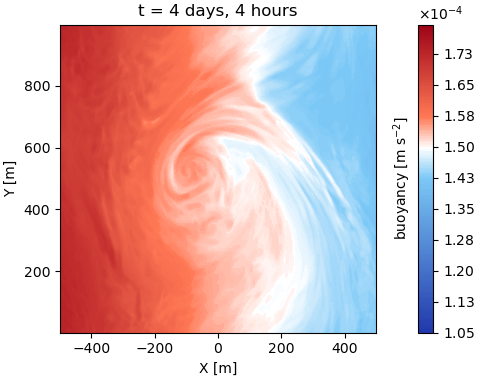

In [86]:
colorlist = ['xkcd:sapphire', 'xkcd:lightblue', 'white', 'xkcd:melon', 'xkcd:carmine']
nodes = [0.0, 0.5, 0.6, 0.7, 1.0]
cmap = LinearSegmentedColormap.from_list('buoyancy', list(zip(nodes, colorlist)))

itime = 100
xroll = -280

bmin = (top_uf.b.isel(zC=0) + bak.B.isel(zC=-1)).min()
bmax = (top_uf.b.isel(zC=0) + bak.B.isel(zC=-1)).max()
bmin = np.floor(bmin*1e6)/1e6
bmax = np.ceil(bmax*1e6)/1e6
kw = {
    'vmin': bmin,
    'vmax': bmax,
    'levels': np.linspace(bmin, bmax, 200),
    'cmap': cmap#'Spectral_r'
}

plt.close()
fig = plt.figure(figsize=(4.8,3.8), constrained_layout=True)
ax = fig.add_subplot(111)

Ct = ax.contourf(top_uf.xC, top_uf.yC, top_uf.b.isel(time=itime).squeeze().roll(xC=xroll,yC=0) + bak.B.isel(zC=-1), **kw);
ax.set_title(f't = {itime//24} days, {itime%24} hours')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
cbar = fig.colorbar(Ct, ax=ax, fraction=0.5, pad=0.05, format=FormatScalarFormatter('%.2f'))
cbar.set_label(r'buoyancy [m s$^{-2}$]', labelpad=-60)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.yaxis.set_offset_position('left')
# plt.savefig('../Figures/btop_217.png', dpi=150)

# def update(frame):
#     global Ct, top, bak, kw, xroll
#     # for each frame, get new data and clear old data stored on each artist
#     top_field = (top.b.isel(time=frame,zC=0).roll(xC=xroll,yC=0)  + bak.B.isel(zC=-1))
#     with warnings.catch_warnings():
#         warnings.simplefilter('ignore')
#         for coll in Ct.collections:
#             coll.remove()
#     # update the plot
#     Ct = ax.contourf(top.xC, top.yC, top_field, **kw)
#     ax.set_title(f't = {frame//24} days, {frame%24} hours');
#     return Ct

# ani = animation.FuncAnimation(fig=fig, func=update, frames=top.dims['time'], #top.dims['time']
#                               interval=120, repeat_delay=100, blit=True);
# plt.close()
# display(HTML(ani.to_jshtml()));
# ani.save('../Figures/'+case+'_btop.mp4', writer='ffmpeg', fps=5, dpi=150);

### 3D snapshot/movie

#### buoyancy field

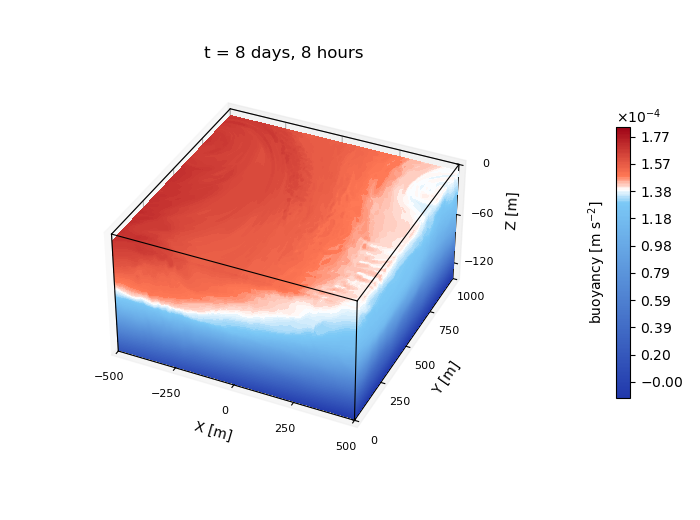

In [36]:
colorlist = ['xkcd:sapphire', 'xkcd:lightblue', 'white', 'xkcd:melon', 'xkcd:carmine']
nodes = [0.0, 0.72, 0.77, 0.82, 1.0]
cmap = LinearSegmentedColormap.from_list('buoyancy', list(zip(nodes, colorlist)))

# Define dimensions
Nx, Ny, Nz = 512, 512, 64
X, Y, Z = np.meshgrid(south.xC, east.yC, east.zC)

itime = 200
xroll = 0
bmin = min([(top.b.isel(zC=0) + bak.B.isel(zC=-1)).min(), 
            (east.b.isel(xC=0) + bak.B.isel(xC=-1)).min(), 
            (south.b.isel(yC=0) + bak.B.isel(yC=0)).min()])
bmax = max([(top.b.isel(zC=0) + bak.B.isel(zC=-1)).max(), 
            (east.b.isel(xC=0) + bak.B.isel(xC=-1)).max(), 
            (south.b.isel(yC=0) + bak.B.isel(yC=0)).max()])
bmin = np.floor(bmin*1e6)/1e6
bmax = np.ceil(bmax*1e6)/1e6
kw = {
    'vmin': bmin,
    'vmax': bmax,
    'levels': np.linspace(bmin, bmax, 200),
    'cmap': cmap#'Spectral_r'
}

# Create a figure with 3D ax
plt.close()
fig = plt.figure(figsize=(7, 5.2))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
Ct = ax.contourf(
    X[:, :, -5], Y[:, :, -5], (top.b.isel(time=itime,zC=0).roll(xC=xroll) + bak.B.isel(zC=-5)).transpose('yC','xC'),
    zdir='z', offset=east.zC[-5], **kw
)
Cs = ax.contourf(
    X[0, :, :-4], (south.b.isel(time=itime,yC=0,zC=slice(0,-4)).roll(xC=xroll) + bak.B.isel(yC=0,zC=slice(0,-4))).transpose('xC','zC'), Z[0, :, :-4],
    zdir='y', offset=0, **kw
)
Ce = ax.contourf(
    (east.b.isel(time=itime,xC=0,zC=slice(0,-4)) + bak.B.isel(xC=-1,zC=slice(0,-4))).transpose('yC','zC'), Y[:, -1, :-4], Z[:, -1, :-4],
    zdir='x', offset=X.max(), **kw
)
# --

# Plot edges
xmin, xmax = -500, 500
ymin, ymax = 0, 1000
zmin, zmax = -140, 0
edges_kw = dict(color='k', linewidth=0.8, zorder=1e3)
ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
ax.plot([xmin, xmin], [ymin, ymin], [zmin, zmax], **edges_kw)
ax.plot([xmin, xmin], [ymin, ymax], [zmax, zmax], **edges_kw)
ax.plot([xmin, xmax], [ymax, ymax], [zmax, zmax], **edges_kw)

# Set labels and zticks
ax.set(
    xlabel='X [m]',
    ylabel='Y [m]',
    zlabel='Z [m]',
    zticks=[0, -60, -120],
    xticks=[-500, -250, 0, 250, 500],
    yticks=[0, 250, 500, 750, 1000]
)
ax.tick_params(axis='both', labelsize=8)

# Set zoom and angle view
ax.view_init(35, -65, 0)
ax.set_box_aspect((1,1,0.55), zoom=1)

# Colorbar
cbar = fig.colorbar(Ct, ax=ax, fraction=0.025, pad=0.25, format=FormatScalarFormatter('%.2f'))
cbar.set_label(r'buoyancy [m s$^{-2}$]', labelpad=-70)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.yaxis.set_offset_position('left')
# Set limits of the plot from coord limits
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax]);
ax.set_title(f't = {itime//24} days, {itime%24} hours');

# plt.savefig('../Figures/b3d_initial.png', dpi=150)
# plt.savefig('../Figures/b3d_mid.png', dpi=150)

# def update(frame):
#     global Ct, Cs, Ce, top, south, east, bak, X, Y, Z, kw
#     # for each frame, get new data and clear old data stored on each artist
#     top_field = (top.b.isel(time=frame,zC=0).roll(xC=xroll) + bak.B.isel(zC=-5)).transpose('yC','xC')
#     south_field = (south.b.isel(time=frame,yC=0,zC=slice(0,-4)).roll(xC=xroll) + bak.B.isel(yC=0,zC=slice(0,-4))).transpose('xC','zC')
#     east_field = (east.b.isel(time=frame,xC=0,zC=slice(0,-4)) + bak.B.isel(xC=-1,zC=slice(0,-4))).transpose('yC','zC')
#     with warnings.catch_warnings():
#         warnings.simplefilter('ignore')
#         for coll in Ct.collections:
#             coll.remove()
#         for coll in Cs.collections:
#             coll.remove()
#         for coll in Ce.collections:
#             coll.remove()
#     # update the plot
#     Ct = ax.contourf(X[:, :, -5], Y[:, :, -5], top_field, zdir='z', offset=east.zC[-5], **kw)
#     Cs = ax.contourf(X[0, :, :-4], south_field, Z[0, :, :-4], zdir='y', offset=0, **kw)
#     Ce = ax.contourf(east_field, Y[:, -1, :-4], Z[:, -1, :-4], zdir='x', offset=X.max(), **kw)
#     ax.set_title(f't = {frame//24} days, {frame%24} hours');
#     return (Ct, Cs, Ce)

# ani = animation.FuncAnimation(fig=fig, func=update, frames=180,#top.dims['time'], 
#                               interval=120, repeat_delay=100, blit=True);#
# plt.close()
# display(HTML(ani.to_jshtml()));
# ani.save('../Figures/'+case+'_b3d.mp4', writer='ffmpeg', fps=5, dpi=150);

#### vertical velocity field

/glade/scratch/zhihuaz/ipykernel_75864/4213078828.py:102: UserWarning: The following kwargs were not used by contour: 'zdir', 'offset'
  Ce = ax.contourf(east_field, Y[:, -1, :], Z[:, -1, :], zdir='x', offset=X.max(), **kw)
/glade/scratch/zhihuaz/ipykernel_75864/4213078828.py:100: UserWarning: The following kwargs were not used by contour: 'zdir', 'offset'
  Ct = ax.contourf(X[:, :, -1], Y[:, :, -1], top_field, zdir='z', offset=0, **kw)
/glade/scratch/zhihuaz/ipykernel_75864/4213078828.py:101: UserWarning: The following kwargs were not used by contour: 'zdir', 'offset'
  Cs = ax.contourf(X[0, :, :], south_field, Z[0, :, :], zdir='y', offset=0, **kw)
/glade/scratch/zhihuaz/ipykernel_75864/4213078828.py:102: UserWarning: The following kwargs were not used by contour: 'zdir', 'offset'
  Ce = ax.contourf(east_field, Y[:, -1, :], Z[:, -1, :], zdir='x', offset=X.max(), **kw)


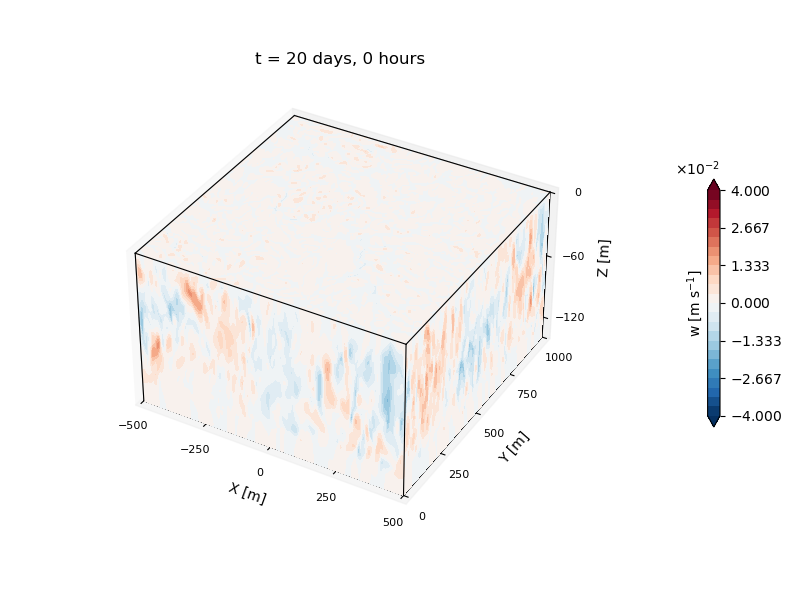

In [42]:
Nx, Ny, Nz = 256, 256, 65
X, Y, Z = np.meshgrid(south.xC, east.yC, east.zF)
itime = 0

wmin = min([top.w.isel(zF=0).min(), 
            east.w.isel(xC=0).min(), 
            south.w.isel(yC=0).min()])
wmax = max([top.w.isel(zF=0).max(), 
            east.w.isel(xC=0).max(), 
            south.w.isel(yC=0).max()])
wamp = np.floor(max([abs(wmin), abs(wmax)])*1e2)/1e2

kw = {
    'vmin': -wamp,
    'vmax': wamp,
    'levels': np.linspace(-wamp, wamp, 25),
    'cmap': 'RdBu_r',
    'extend': 'both'
}

# Create a figure with 3D ax
plt.close()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
Ct = ax.contourf(
    X[:, :, -1], Y[:, :, -1], top.w.isel(time=itime,zF=0).transpose('yC','xC'),
    zdir='z', offset=0, **kw
)
Cs = ax.contourf(
    X[0, :, :], south.w.isel(time=itime,yC=0).transpose('xC','zF'), Z[0, :, :],
    zdir='y', offset=0, **kw
)
Ce = ax.contourf(
    east.w.isel(time=itime,xC=0).transpose('yC','zF'), Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw
)
# --

# Plot edges
ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
ax.plot([xmin, xmin], [ymin, ymin], [zmin, zmax], **edges_kw)
ax.plot([xmin, xmin], [ymin, ymax], [zmax, zmax], **edges_kw)
ax.plot([xmin, xmax], [ymax, ymax], [zmax, zmax], **edges_kw)

# Set labels and zticks
ax.set(
    xlabel='X [m]',
    ylabel='Y [m]',
    zlabel='Z [m]',
    zticks=[0, -60, -120],
    xticks=[-500, -250, 0, 250, 500],
    yticks=[0, 250, 500, 750, 1000]
)
ax.tick_params(axis='both', labelsize=8)

# Set zoom and angle view
ax.view_init(35, -60, 0)
ax.set_box_aspect((1,1,0.6), zoom=1)

# Colorbar
cbar = fig.colorbar(Ce, ax=ax, fraction=0.02, pad=0.22)
cbar.set_label(r'w [m s$^{-1}$]', labelpad=-70)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.set_yticks(np.linspace(-wamp, wamp, 7))

# Set limits of the plot from coord limits
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax]);
ax.set_title(f't = {itime//24} days, {itime%24} hours');

# plt.savefig('../Figures/b3d_initial.png', dpi=150)
# plt.savefig('../Figures/b3d_mid.png', dpi=150)


def update(frame):
    global Ct, Cs, Ce, top, south, east, X, Y, Z, kw
    # for each frame, get new data and clear old data stored on each artist
    top_field = top.w.isel(time=frame,zF=0).transpose('yC','xC')
    south_field = south.w.isel(time=frame,yC=0).transpose('xC','zF')
    east_field = east.w.isel(time=frame,xC=0).transpose('yC','zF')
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for coll in Ct.collections:
            coll.remove()
        for coll in Cs.collections:
            coll.remove()
        for coll in Ce.collections:
            coll.remove()
    # update the plot
    Ct = ax.contourf(X[:, :, -1], Y[:, :, -1], top_field, zdir='z', offset=0, **kw)
    Cs = ax.contourf(X[0, :, :], south_field, Z[0, :, :], zdir='y', offset=0, **kw)
    Ce = ax.contourf(east_field, Y[:, -1, :], Z[:, -1, :], zdir='x', offset=X.max(), **kw)
    ax.set_title(f't = {frame//24} days, {frame%24} hours');
    return (Ct, Cs, Ce)

ani = animation.FuncAnimation(fig=fig, func=update, frames=top.dims['time'], interval=120, repeat_delay=100);#
plt.close()
display(HTML(ani.to_jshtml()));
ani.save('../Figures/'+case+'_w3d.mp4', writer='ffmpeg', fps=5, dpi=150);

In [61]:
np.sqrt(1.8e-6)

0.0013416407864998738